In [1]:
#libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split

from keras.layers import Dense, Input, Flatten, Reshape
#from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout, LSTM, GRU, Bidirectional, concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, Concatenate
from keras.models import Model, Sequential
from keras.utils import to_categorical

from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import optimizers
from keras import regularizers
from keras.utils.layer_utils import print_summary
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import CSVLogger

def kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

Using TensorFlow backend.


In [2]:
breeds = pd.read_csv('./all/breed_labels.csv')
colors = pd.read_csv('./all/color_labels.csv')
states = pd.read_csv('./all/state_labels.csv')

data = pd.read_csv('./all/train.csv')

all_data = data

In [3]:
data['Breed1'] = data['Breed1'].map(breeds.set_index('BreedID')['BreedName'])
data['Breed2'] = data['Breed2'].map(breeds.set_index('BreedID')['BreedName'])

data['State'] = data['State'].map(states.set_index('StateID')['StateName'])

data['Color1'] = data['Color1'].map(colors.set_index('ColorID')['ColorName'])
data['Color2'] = data['Color2'].map(colors.set_index('ColorID')['ColorName'])
data['Color3'] = data['Color3'].map(colors.set_index('ColorID')['ColorName'])

genderDict = {1:'Male', 2:'Female', 3:'Mixed'}
typeDict = {1:'Dog', 2:'Cat'}
maturityDict = {1: 'Small', 2: 'Medium', 3: 'Large', 4: 'Extra Large', 0: 'Not Specified'}
healthDict = {1:'Healthy', 2:'Minor Injury', 3:'Serious Injury', 0:'Not Specified'}
furDict = {1: 'Short', 2: 'Medium', 3: 'Long', 0: 'Not Specified'}

data['Gender'] = data['Gender'].map(genderDict)
data['Type'] = data['Type'].map(typeDict)
data['MaturitySize'] = data['MaturitySize'].map(maturityDict)
data['Health'] = data['Health'].map(healthDict)
data['FurLength'] = data['FurLength'].map(furDict)

In [3]:
data_label = data.AdoptionSpeed
#We drop name because it creates a huge embedding vector and we know that name is not very useful anyway
data = data.drop(['AdoptionSpeed', 'Name'], axis=1)

In [ ]:
#Add Name as a binary label


In [5]:
data

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt
0,2,3,299,0,1,1,7,0,1,1,2,2,2,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care.,86e1089a3,1.0
1,2,1,265,0,1,1,2,0,2,2,3,3,3,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartment. It was shaking so I had to bring it home to provide temporary care.,6296e909a,2.0
2,1,1,307,0,1,2,7,0,2,2,1,1,2,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,"Their pregnant mother was dumped by her irresponsible owner at the roadside near some shops in Subang Jaya. Gave birth to them at the roadside. They are all healthy and adorable puppies. Already dewormed, vaccinated and ready to go to a home. No tying or caging for long hours as guard dogs. However, it is acceptable to cage or tie for precautionary purposes. Interested to adopt pls call me.",3422e4906,7.0
3,1,4,307,0,2,1,2,0,2,1,1,1,2,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience waiting for her good master, plz call or sms for more details if you really get interested, thanks!!",5842f1ff5,8.0
4,1,1,307,0,1,1,0,0,2,1,2,2,2,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,"This handsome yet cute boy is up for adoption. He is the most playful pal we've seen in our puppies. He loves to nibble on shoelaces , Chase you at such a young age. Imagine what a cute brat he will be when he grows. We are looking for a loving home for Hunter , one that will take care of him and give him the love that he needs. Please call urgently if you would like to adopt this cutie.",850a43f90,3.0
5,2,3,266,0,2,5,6,0,2,1,2,2,2,1,1,0,41326,22fe332bf9c924d4718005891c63fbed,0,"This is a stray kitten that came to my house. Have been feeding it, but cannot keep it.",d24c30b4b,2.0
6,2,12,264,264,1,1,0,0,2,3,2,2,3,1,1,300,41326,1e0b5a458b5b77f5af581d57ebf570b3,0,anyone within the area of ipoh or taiping who interested to adopt my cat can contact my father at this number (mazuvil)or can just email me. currently bulat is at my hometown at perak but anyone outside the area still want to adopt can travel there to my hometown.there is a lot of cats in my house rite now..i think i should let one of them go to a better owner who can give better attention to him.,1caa6fcdb,3.0
7,1,0,307,0,2,1,2,7,2,1,2,2,2,1,6,0,41326,1fba5f6e5480946254590d48f9c5198d,0,Siu Pak just give birth on 13/6/10 to 6puppies. Interested pls call or sms me. Left 2female puppies on 2/7/10,97aa9eeac,9.0
8,2,2,265,0,2,6,0,0,2,2,2,2,2,1,1,0,41326,d8af7afece71334473575c9f70daf00d,0,"healthy and active, feisty kitten found in neighbours' garden. Not sure of sex.",c06d167ca,6.0
9,2,12,265,0,2,1,7,0,2,2,3,3,3,1,1,0,41326,1f3f36e4b18e94855b3e88af0852fdc4,0,"Very manja and gentle stray cat found, we would really like to find a home for it because we cannot keep her for ourselves for long. Has a very cute high pitch but soft meow. Please contact me if you would be interested in adopting.",7a0942d61,2.0


In [4]:
train, test, train_label, test_label = train_test_split(data, data_label, test_size=0.2, random_state=9)

#Turn labels into n dimensional vectors for loss calculation
train_label = to_categorical(train_label, num_classes=None)
test_label = to_categorical(test_label, num_classes=None)

In [7]:
train.drop('Description', axis=1).head()

,Type,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,FurLength,Vaccinated,Dewormed,Sterilized,Health,Quantity,Fee,State,RescuerID,VideoAmt,PetID,PhotoAmt
7236,2,1,265,0,2,1,2,6,2,2,2,2,2,1,1,0,41336,7cb867bc9aabe81e7e26780a93bb57ea,0,c15c93964,3.0
1782,1,2,141,307,1,6,7,0,2,2,2,2,2,1,1,0,41401,88da1210e021a5cf43480b074778f3bc,0,91f5bb21f,1.0
4359,1,2,307,307,1,1,2,0,2,2,1,1,2,1,1,0,41326,b53c34474d9e24574bcec6a3d3306a0d,0,6202e7d4d,5.0
13445,2,19,266,266,1,4,0,0,2,1,1,1,1,1,1,0,41326,13733222f015ec6a0017c3c0527738ff,0,4b932ab38,5.0
11184,2,4,266,0,1,2,7,0,1,1,1,1,2,1,1,0,41401,c00756f2bdd8fa88fc9f07a8309f7d5d,0,e9292cee2,5.0


In [8]:
categorical_vars = ['Type', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
        'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
        'Sterilized', 'Health', 'State']
numerical_vars = ['Age', 'Quantity', 'Fee', 'VideoAmt', 'PhotoAmt']

In [111]:
#Creating a Embedding model for categorical variables using the fast.ai approach
def createEmbeddingsModel(data, categorical_vars, numerical_vars):
    embeddings = []
    inputs = []
    for categorical_var in categorical_vars :
        i = Input(shape=(1,))
        model = Sequential()
        no_of_unique_cat  = data[categorical_var].nunique()
        embedding_size = min(np.ceil((no_of_unique_cat)/2), 50 )
        embedding_size = int(embedding_size)
        vocab  = no_of_unique_cat+1
        embedding = Embedding(vocab ,embedding_size, input_length = 1 )(i)
        embedding = Reshape(target_shape=(embedding_size,))(embedding)
        embeddings.append( embedding )
        inputs.append(i)
        
    input_numeric = Input(shape=(len(numerical_vars),))
    embedding_numeric = Dense(16)(input_numeric) 
    inputs.append(input_numeric)
    embeddings.append(embedding_numeric)
    
    x = Concatenate()(embeddings)
    x = Dense(80, activation='relu')(x)
    x = Dropout(.35)(x)
    x = Dense(20, activation='relu')(x)
    x = Dropout(.15)(x)
    x = Dense(10, activation='relu')(x)
    x = Dropout(.15)(x)
    output = Dense(5, activation='sigmoid')(x)

    model = Model(inputs, output)
    model.compile(metrics=['accuracy'], loss='categorical_crossentropy', optimizer='adam')
    return model

In [112]:
model = createEmbeddingsModel(train, categorical_vars, numerical_vars)

In [113]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_35 (

In [114]:
def preproc(X_train, X_test, embed_cols, num_cols):

    input_list_train = []
    input_list_test = []
    m= MinMaxScaler()
        
    #the cols to be embedded: rescaling to range [0, # values)
    for c in embed_cols:
        raw_vals = np.unique(X_train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        m.fit(X_train[c].map(val_map).values.reshape(-1, 1))
        input_list_train.append(m.transform(X_train[c].map(val_map).values.reshape(-1, 1)))
        
        m.fit(X_test[c].map(val_map).fillna(0).values.reshape(-1, 1))
        input_list_test.append(m.transform(X_test[c].map(val_map).fillna(0).values.reshape(-1, 1)))
        
    #the numerical columns
    m.fit(X_train[num_cols].values)
    input_list_train.append(m.transform(X_train[num_cols].values))
    
    m.fit(X_test[num_cols].values)
    input_list_test.append(m.transform(X_test[num_cols].values))
    
    return input_list_train, input_list_test

In [115]:
X_train, X_test = preproc(train, test, categorical_vars, numerical_vars)

In [144]:
hist = model.fit(X_train, train_label, batch_size=64 ,epochs=50, validation_split=0.1, shuffle=True)

Train on 9040 samples, validate on 1005 samples
Epoch 1/50
9040/9040 [==============================] - 1s 143us/step - loss: 1.3125 - acc: 0.4187 - val_loss: 1.2857 - val_acc: 0.4289
Epoch 2/50
9040/9040 [==============================] - 1s 141us/step - loss: 1.3121 - acc: 0.4219 - val_loss: 1.2915 - val_acc: 0.4308
Epoch 3/50
9040/9040 [==============================] - 1s 136us/step - loss: 1.3175 - acc: 0.4185 - val_loss: 1.3006 - val_acc: 0.4129
Epoch 4/50
9040/9040 [==============================] - 1s 138us/step - loss: 1.3118 - acc: 0.4165 - val_loss: 1.2930 - val_acc: 0.4239
Epoch 5/50
9040/9040 [==============================] - 1s 142us/step - loss: 1.3166 - acc: 0.4167 - val_loss: 1.2959 - val_acc: 0.4269
Epoch 6/50
9040/9040 [==============================] - 1s 136us/step - loss: 1.3158 - acc: 0.4131 - val_loss: 1.2934 - val_acc: 0.4279
Epoch 7/50
9040/9040 [==============================] - 1s 140us/step - loss: 1.3159 - acc: 0.4115 - val_loss: 1.2894 - val_acc: 0.4209


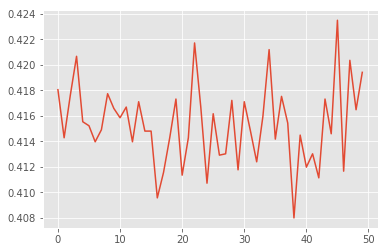

In [142]:
plt.plot(hist.history['acc'])


In [143]:
model.evaluate(X_test, test_label)

4948/4948 [==============================] - 0s 73us/step


[1.3902515651915666, 0.3773241713341919]